In [211]:
!pwd

/Users/daniel.hunter/code/myblog/posts/post-with-code


In [8]:
img = Image.open(Path.home() / 'Downloads' / 'AvatarAI.me' / '61.jpg')

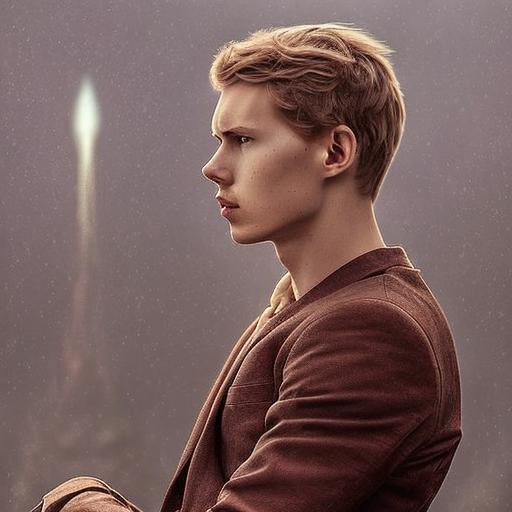

In [84]:
img

In [25]:
import numpy as np
import torch
from torchvision import transforms

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])


def deprocess(image_np):
    image_np = image_np.squeeze().transpose(1, 2, 0)
    image_np = image_np * std.reshape((1, 1, 3)) + mean.reshape((1, 1, 3))
    image_np = np.clip(image_np, 0.0, 255.0)
    return image_np


def clip(image_tensor):
    for c in range(3):
        m, s = mean[c], std[c]
        image_tensor[0, c] = torch.clamp(image_tensor[0, c], -m / s, (1 - m) / s)
    return image_tensor

In [208]:
from torch.autograd import Variable
from tqdm.auto import tqdm
import scipy.ndimage as nd


def dream(image, model, iterations, lr):
    """ Updates the image to maximize outputs for n iterations """
    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
    image = Variable(Tensor(image), requires_grad=True)
    for i in range(iterations):
        model.zero_grad()
        out = model(image)
        # label = [00000,1,00000]
        label = torch.zeros(1, dtype=torch.long)
        label[0] = 779
        loss = nn.CrossEntropyLoss()(out, label)
        # import pdb ; pdb.set_trace()
        # loss = out.norm()
        loss.backward()
        avg_grad = np.abs(image.grad.data.cpu().numpy()).mean()
        norm_lr = lr / avg_grad
        image.data += norm_lr * image.grad.data
        image.data = clip(image.data)
        image.grad.data.zero_()
    return image.cpu().data.numpy()


def deep_dream(image, model, iterations, lr, octave_scale, num_octaves):
    """ Main deep dream method """
    image = preprocess(image).unsqueeze(0).cpu().data.numpy()

    # Extract image representations for each octave
    octaves = [image]
    for _ in range(num_octaves - 1):
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1 / octave_scale, 1 / octave_scale), order=1))

    detail = np.zeros_like(octaves[-1])
    for octave, octave_base in enumerate(tqdm(octaves[::-1], desc="Dreaming")):
        if octave > 0:
            # Upsample detail to new octave dimension
            detail = nd.zoom(detail, np.array(octave_base.shape) / np.array(detail.shape), order=1)
        # Add deep dream detail from previous octave to new base
        input_image = octave_base + detail
        # Get new deep dream image
        dreamed_image = dream(input_image, model, iterations, lr)
        # Extract deep dream details
        detail = dreamed_image - octave_base

    return deprocess(dreamed_image)

In [209]:
import torch
from torch import nn
from torchvision import models

# Define the model
network = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
# layers = list(network.features.children())
model = network # nn.Sequential(*layers[: (27 + 1)])
if torch.cuda.is_available():
    model = model.cuda()
# print(network)

# Extract deep dream image
dreamed_image = deep_dream(
    img,
    model,
    iterations=30,
    lr=0.03,
    octave_scale=1.4,
    num_octaves=5,
)

Dreaming:   0%|          | 0/5 [00:00<?, ?it/s]

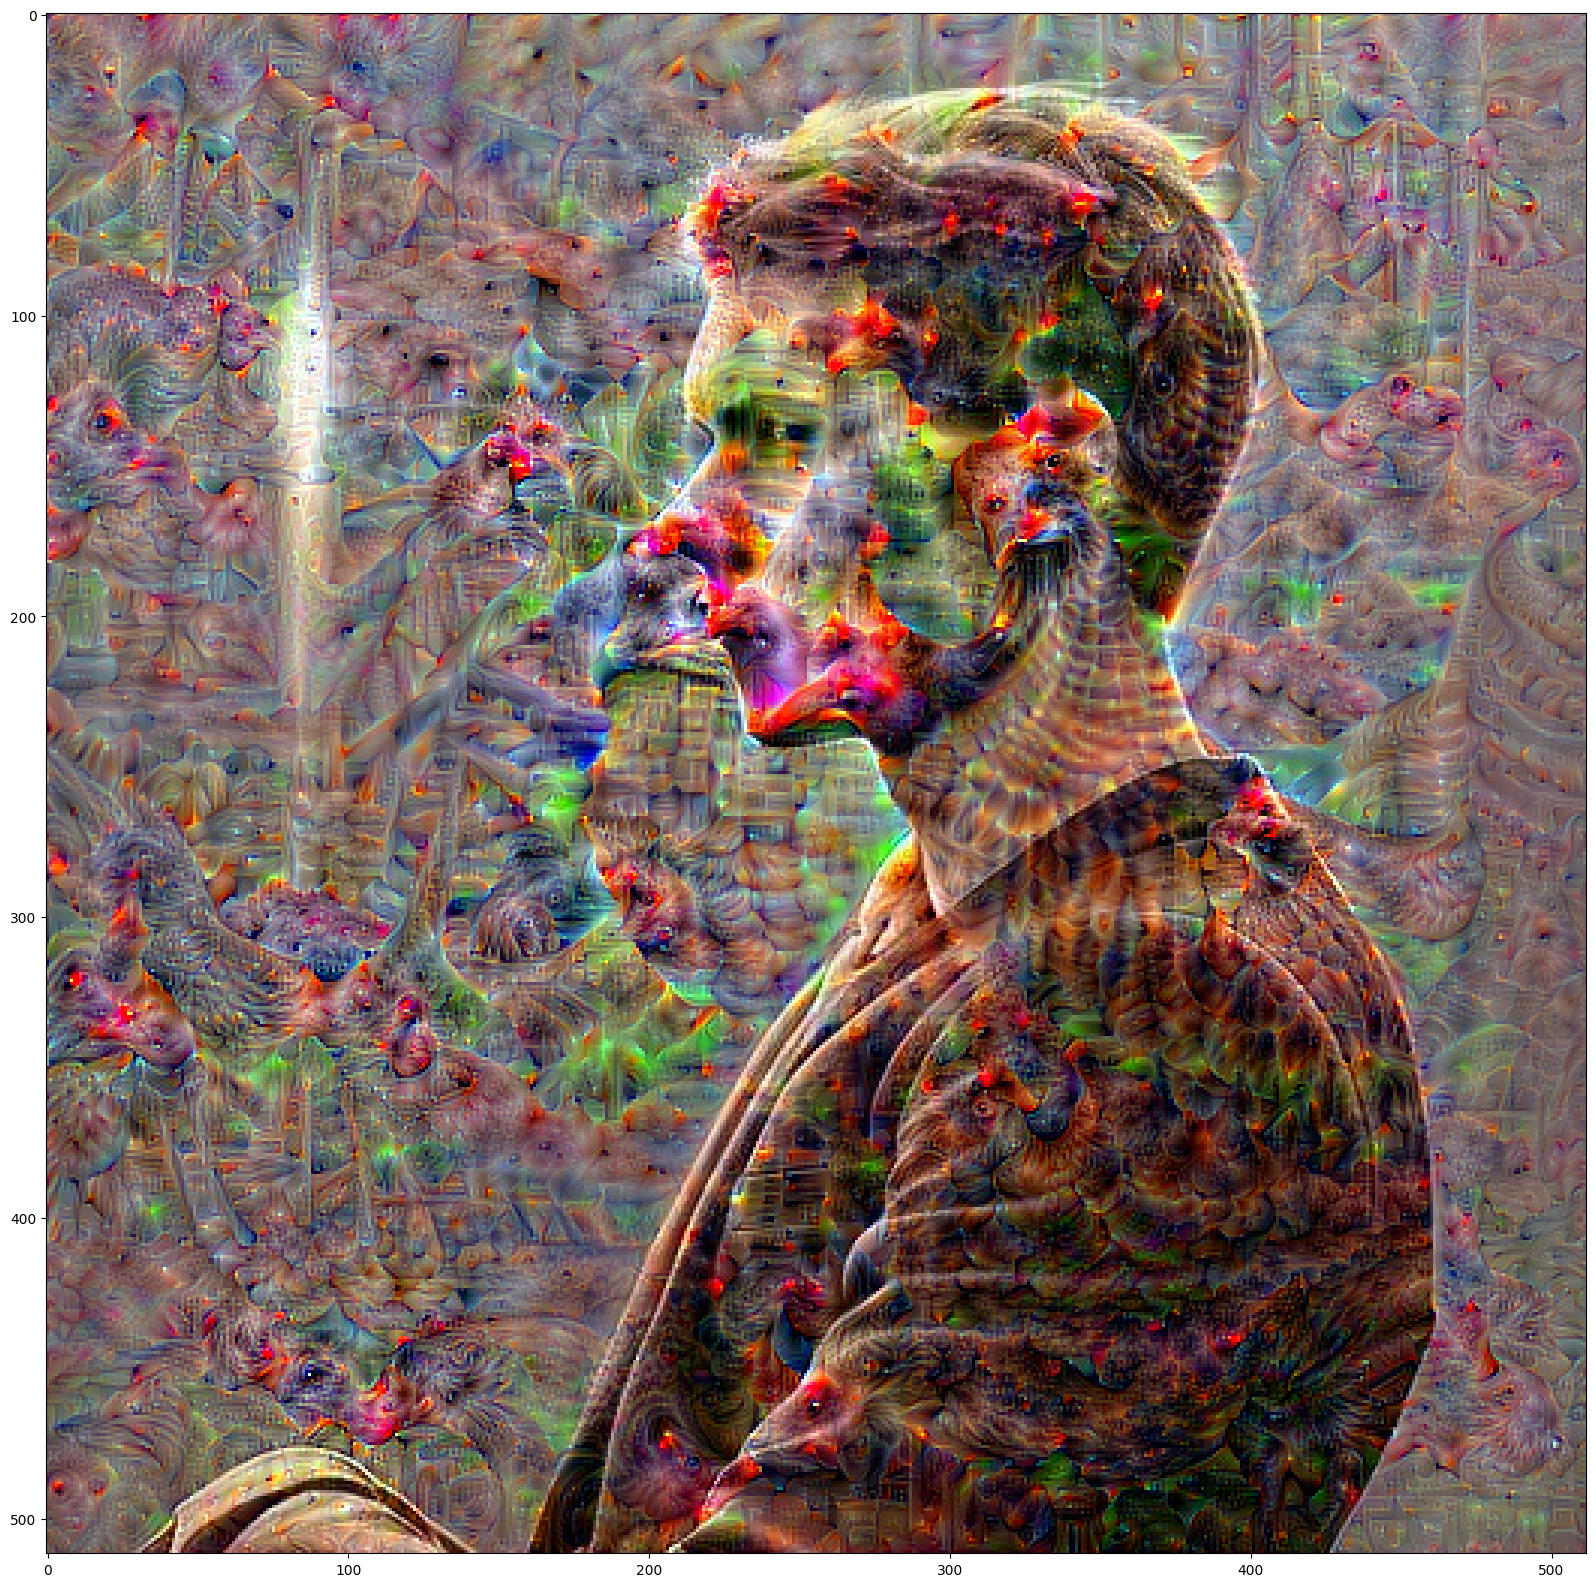

In [210]:
viz(dreamed_image)

In [88]:
np.array(img).shape

(512, 512, 3)

In [91]:
nd.zoom(np.array(img), (1 / 1.4, 1 / 1.4, 1), order=1).shape

(366, 366, 3)

In [123]:
len(dreamed_image)

10

In [151]:
from more_itertools import zip_equal
import matplotlib.pyplot as plt

def prep_img(arr):
    if isinstance(arr, Image.Image):
        arr = np.array(arr)
    arr = arr.squeeze()
    if arr.shape[0] == 3:
        arr = arr.transpose((1,2,0))
    _H, _W, C = arr.shape
    assert C == 3, arr.shape
    if arr.dtype in [np.float32, np.float64]:
        arr = np.clip(a=arr, a_min=0, a_max=1)
    elif arr.dtype in [np.uint8]:
        arr = np.clip(a=arr, a_min=0, a_max=255)
    else:
        raise ValueError(arr.dtype)
    return arr

def viz(*arrs, ncols=1):
    fig, axs = plt.subplots(nrows=len(arrs), ncols=ncols, figsize=(20,20), squeeze=False)
    for arr, ax in zip_equal(arrs, axs.ravel()):
        # import pdb ; pdb.set_trace()
        ax.imshow(prep_img(arr))

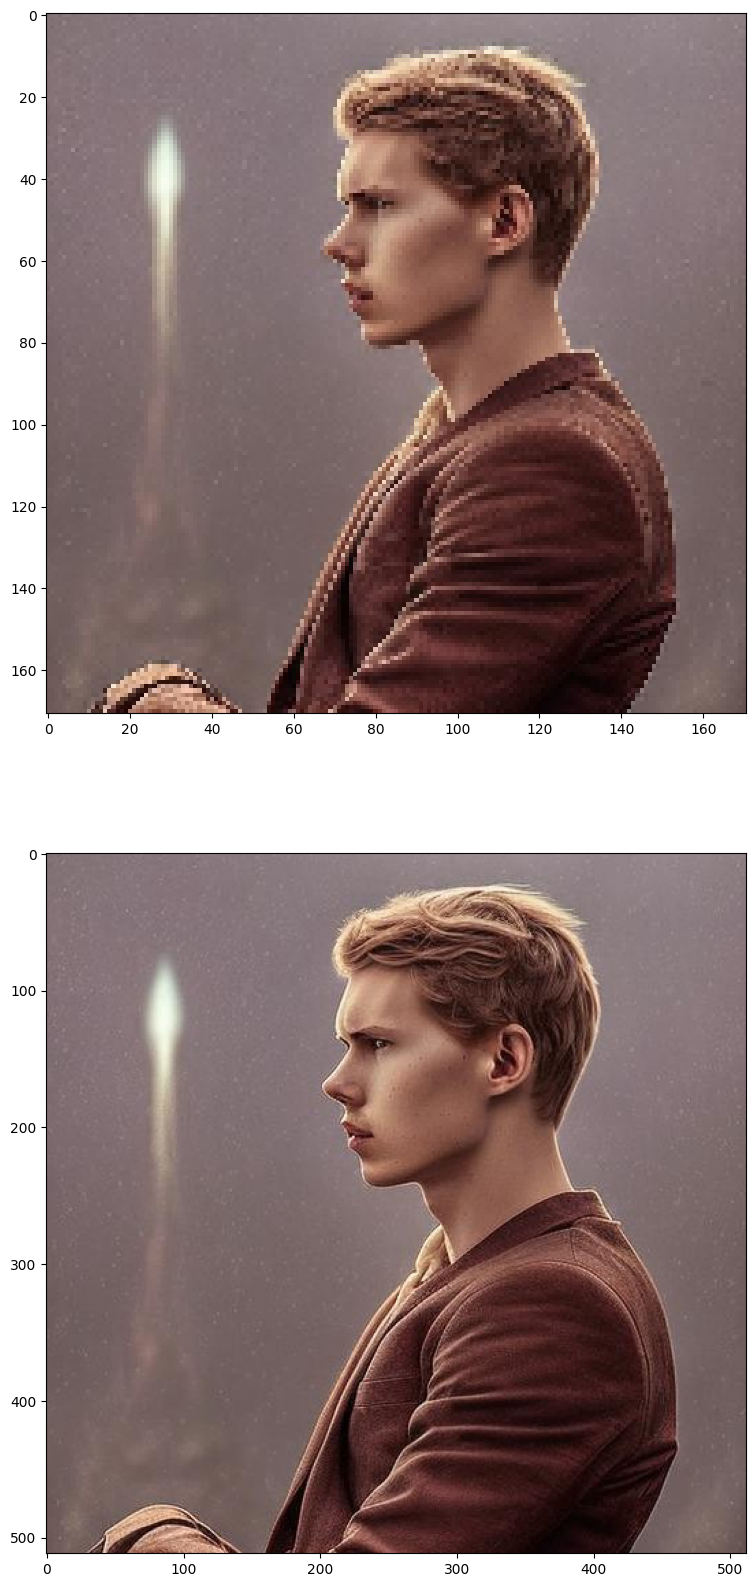

In [152]:
viz(
    # dreamed_image[0],
    # dreamed_image[5],
    # dreamed_image[9],
    nd.zoom(np.array(img), (1 / 3, 1 / 3, 1), order=1),
    img,
)